In [0]:
!pip install --upgrade tensorflow

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.2.0)


In [0]:
import tensorflow 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten, GlobalAveragePooling2D, Activation, Reshape, LeakyReLU, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from sklearn import svm
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os

from google.colab import drive
drive.mount('/content/gdrive')

from cluster_data_creation import data_for_cluster, cluster_extract

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# load data
xls = pd.ExcelFile('gdrive/My Drive/CTG.xls')
data = pd.read_excel(xls, 'Data')

In [0]:
# strings of feature names for reference
# of 21 features
feat_num = 21
classes = 3
feature_names = np.array([data[i][0] for i in range(1, feat_num+classes)])

# 2126 examples
N = 2126

# split into 80: 20 for test: train data
train_num = int(N*0.8)

# load train data
train_data = np.array([[data[i][j] for i in range(1, feat_num+1)]
                                 for j in range(1, train_num+1)])
# load train labels
train_labels = np.array([data[23][i] for i in range(1, train_num+1)])
# load test data
test_data = np.array([[data[i][j] for i in range(1, feat_num+1)]
                                 for j in range(train_num+1, N+1)])
# load test labels
test_labels = np.array([data[23][i] for i in range(train_num+1, N+1)])

# view data for first example
print("Example 1 features:\n")
for i in range(feat_num):
  print(feature_names[i], ' '*(8-len(feature_names[i])), '|', train_data[0][i], ' '*(6-len(str(train_data[0][i]))))
# view labels for first example
print("\nLabels:\n")
print(feature_names[22], ' '*(8-len(feature_names[i])), '|', train_labels[0])

Example 1 features:

LB        | 120.0  
AC        | 0.0    
FM        | 0.0    
UC        | 0.0    
DL        | 0.0    
DS        | 0.0    
DP        | 0.0    
ASTV      | 73.0   
MSTV      | 0.5    
ALTV      | 43.0   
MLTV      | 2.4    
Width     | 64.0   
Min       | 62.0   
Max       | 126.0  
Nmax      | 2.0    
Nzeros    | 0.0    
Mode      | 120.0  
Mean      | 137.0  
Median    | 121.0  
Variance  | 73.0   
Tendency  | 1.0    

Labels:

NSP  | 2


## **Getting rid of outliers:**

In [0]:
# get all data:
data_features = np.array([[data[i][j] for i in range(1, feat_num+1)]
                                 for j in range(1, N+1)])
data_labels = np.array([data[23][i] for i in range(1, N+1)])

# **Method 1:** More than 3 Standard Deviations (may or may not work since data may not be in a normal distribution):

In [0]:
# original function from: https://gist.github.com/wmlba/89bc2f4556b8ee397ca7a5017b497657#file-outlier_std-py
# modified below:

# Function to Detection Outlier on one-dimentional datasets.
def find_anomalies(data, factor):
    # Set upper and lower limit to 'factor' standard deviation
    data_std = np.std(data)
    data_mean = np.mean(data)
    anomaly_cut_off = data_std * factor
    
    lower_limit  = data_mean - anomaly_cut_off 
    upper_limit = data_mean + anomaly_cut_off
    anomalies = []
    idxs = []
    i = 0
    # Generate outliers
    for outlier in data:
        if outlier > upper_limit or outlier < lower_limit:
            anomalies.append(outlier)
            idxs.append(i)
        i += 1
    return anomalies, idxs

clusters = cluster_extract(data_features, data_labels)
normals = clusters.get_cluster_from_data(1)

idxs = []

for i in range(21):
  idx = find_anomalies(normals[:,i], 2)[1]
  for i in idx:
    idxs.append(i)

idxs = np.array(idxs)
idxs = np.unique(idxs).shape

new_data = np.delete(data_features, idxs, axis=0)
new_labels = np.delete(data_labels, idxs, axis=0)
new_labels = new_labels - 1
new_N = new_data.shape[0]
new_train = int(new_N*0.8)
new_xtrain = new_data[:new_train]/np.max(new_data[:new_train])
new_ytrain = new_labels[:new_train]
new_xtest = new_data[new_train:]/np.max(new_data[new_train:])
new_ytest = new_labels[new_train:]
print(new_xtrain.shape, new_xtest.shape, new_ytrain.shape, new_ytest.shape)

(1700, 21) (425, 21) (1700,) (425,)


# **Method 2:** Dbscan (Density Based Spatial Clustering of Applications with Noise)

In [0]:
from sklearn.cluster import DBSCAN

elbow = []

x, x1 = 26, 80
for j in range(x, x1):
  # min samples is 176, as counted
  clustering = DBSCAN(eps=j, min_samples=176).fit(data_features)

  idxs = []
  for i in range(len(clustering.labels_)):
    if clustering.labels_[i] == -1:
      idxs.append(i)
  
  if len(idxs) > 0:
    new_data = np.delete(data_features, idxs, axis=0)
    new_labels = np.delete(data_labels, idxs, axis=0)
  else:
    new_data = data_features

  new_labels = new_labels - 1

  new_N = new_data.shape[0]
  new_train = int(new_N*0.8)

  new_xtrain = new_data[:new_train]/np.max(new_data[:new_train])
  new_ytrain = new_labels[:new_train]

  new_xtest = new_data[new_train:]/np.max(new_data[new_train:])
  new_ytest = new_labels[new_train:]

  # to check which eps value gives us the best accuracy on an rbf kernel SVM
  # on elbow plot
  rbf_svc = svm.SVC(kernel='rbf', C=2000, gamma=.09)
  rbf_svc.fit(new_xtrain, new_ytrain)
  rbf_acc = rbf_svc.predict(new_xtest)
  elbow.append(accuracy_score(new_ytest, rbf_acc))

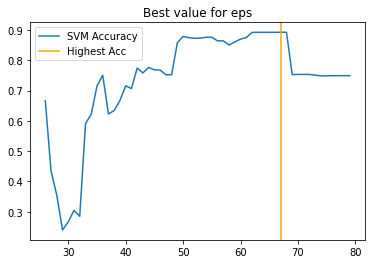

In [0]:
plt.plot([i for i in range(x, x1)], elbow)
plt.title("Best value for eps")

# best value for eps would be one with highest accuracy on SVM
best_eps = x + elbow.index(max(elbow))
plt.axvline(x=best_eps, c='orange')
plt.legend(['SVM Accuracy', 'Highest Acc'])

In [0]:
# finally creating new dataset:
clustering = DBSCAN(eps=best_eps, min_samples=176).fit(data_features)

idxs = []
for i in range(len(clustering.labels_)):
  if clustering.labels_[i] == -1:
    idxs.append(i)

new_data = np.delete(data_features, idxs, axis=0)
new_labels = np.delete(data_labels, idxs, axis=0)
new_labels = new_labels - 1

new_N = new_data.shape[0]
new_train = int(new_N*0.8)

new_xtrain = new_data[:new_train]/np.max(new_data[:new_train])
new_ytrain = new_labels[:new_train]

new_xtest = new_data[new_train:]/np.max(new_data[new_train:])
new_ytest = new_labels[new_train:]

print(new_xtrain.shape, new_xtest.shape, new_ytrain.shape, new_ytest.shape)

(1676, 21) (420, 21) (1676,) (420,)


# KNN Algorithm:

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
model = KNeighborsClassifier(n_neighbors=5)

model.fit(train_data,train_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [0]:
y_pred = model.predict(test_data)
print("Accuracy:",metrics.accuracy_score(test_labels, y_pred))

Accuracy: 0.7676056338028169


Max accuracy: 0.8847058823529412


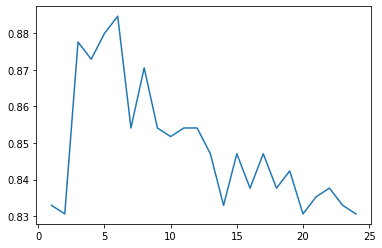

In [0]:
# check for different values of neighbors
accs = []
x1, x2 = 1, 25

for i in range(x1, x2):
  model = KNeighborsClassifier(n_neighbors=i)
  model.fit(new_xtrain,new_ytrain)
  y_pred = model.predict(new_xtest)
  accs.append(metrics.accuracy_score(new_ytest, y_pred))

plt.plot([i for i in range(x1, x2)], accs)
print("Max accuracy:", max(accs))

Data normalization (0 to 1):

In [0]:
n_xtrain = train_data/np.max(train_data)
n_xtest = test_data/np.max(test_data)
y_train = train_labels-1
y_test = test_labels-1

# Linear SVM:

In [0]:
svm_model = svm.LinearSVC(max_iter=10000, C=4.5)
svm_model.fit(n_xtrain, y_train)

LinearSVC(C=4.5, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=10000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [0]:
acc = svm_model.predict(n_xtest)
print("Accuracy: "+str(accuracy_score(y_test, acc)))

Accuracy: 0.8779342723004695


# RBF Kernel SVM

In [0]:
rbf_svc = svm.SVC(kernel='rbf', C=2000, gamma=.09)
rbf_svc.fit(dn_xtrain, y_train)
rbf_acc = rbf_svc.predict(dn_xtest)
print("Accuracy: "+str(accuracy_score(y_test, rbf_acc)))

Accuracy: 0.9366197183098591


# Logistic Regression:

In [0]:
lrmodel = Sequential()

lrmodel.add(Dense(3, activation="softmax"))

In [0]:
lrmodel.compile(optimizer="adam", loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
hist = lrmodel.fit(n_xtrain, y_train, batch_size=128, epochs=50, validation_data=(n_xtest, y_test), kernel_regularizer=regularizers.l2(0.001))

Epoch 1/50
14/14 [==============================] - 0s 8ms/step - loss: 1.2203 - accuracy: 0.1712 - val_loss: 1.2040 - val_accuracy: 0.0235
Epoch 2/50
14/14 [==============================] - 0s 4ms/step - loss: 1.1533 - accuracy: 0.1712 - val_loss: 1.1402 - val_accuracy: 0.0235
Epoch 3/50
14/14 [==============================] - 0s 4ms/step - loss: 1.0926 - accuracy: 0.1712 - val_loss: 1.0824 - val_accuracy: 0.0563
Epoch 4/50
14/14 [==============================] - 0s 4ms/step - loss: 1.0356 - accuracy: 0.2718 - val_loss: 1.0293 - val_accuracy: 0.3850
Epoch 5/50
14/14 [==============================] - 0s 4ms/step - loss: 0.9871 - accuracy: 0.5935 - val_loss: 0.9813 - val_accuracy: 0.7817
Epoch 6/50
14/14 [==============================] - 0s 4ms/step - loss: 0.9410 - accuracy: 0.7688 - val_loss: 0.9391 - val_accuracy: 0.7981
Epoch 7/50
14/14 [==============================] - 0s 4ms/step - loss: 0.9047 - accuracy: 0.7735 - val_loss: 0.9012 - val_accuracy: 0.7981
Epoch 8/50
14/14 [==

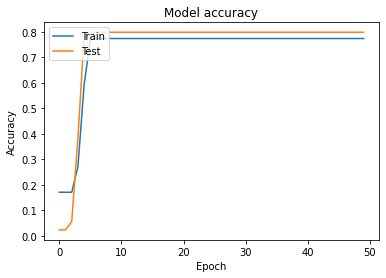

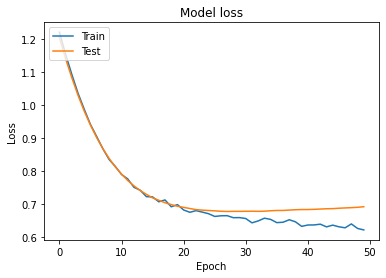

In [0]:
# Plot training & validation accuracy values
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.figure()
# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
result = lrmodel.evaluate(n_xtest, y_test, batch_size=32)
print('test loss, test acc:', result)

14/14 [==============================] - 0s 2ms/step - loss: 0.7359 - accuracy: 0.7981
test loss, test acc: [0.7359370589256287, 0.7981220483779907]


# Dense Layered Neural Network:

Data Normalization (-1 to 0):

In [0]:
dn_xtrain = (train_data - np.max(train_data))/np.max(train_data)
dn_xtest = (test_data - np.max(test_data))/np.max(test_data)

In [0]:
densenn = Sequential()

densenn.add(Dense(128))
densenn.add(LeakyReLU(alpha=0.3))

densenn.add(Dense(8))
densenn.add(LeakyReLU(alpha=0.3))

densenn.add(Dense(3, activation="softmax"))

In [0]:
densenn.compile(optimizer="adam", loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
hist1 = densenn.fit(dn_xtrain, y_train, batch_size=24, epochs=80, validation_data=(dn_xtest, y_test), 
                    kernel_regularizer=regularizers.l2(0.0001))

Epoch 1/80
71/71 [==============================] - 0s 4ms/step - loss: 0.6832 - accuracy: 0.7665 - val_loss: 0.7678 - val_accuracy: 0.7981
Epoch 2/80
71/71 [==============================] - 0s 3ms/step - loss: 0.6160 - accuracy: 0.7735 - val_loss: 0.7669 - val_accuracy: 0.7981
Epoch 3/80
71/71 [==============================] - 0s 3ms/step - loss: 0.5606 - accuracy: 0.7906 - val_loss: 0.9241 - val_accuracy: 0.7653
Epoch 4/80
71/71 [==============================] - 0s 3ms/step - loss: 0.5098 - accuracy: 0.8218 - val_loss: 0.8395 - val_accuracy: 0.7887
Epoch 5/80
71/71 [==============================] - 0s 3ms/step - loss: 0.4796 - accuracy: 0.8229 - val_loss: 0.8494 - val_accuracy: 0.7864
Epoch 6/80
71/71 [==============================] - 0s 3ms/step - loss: 0.4743 - accuracy: 0.8259 - val_loss: 0.8240 - val_accuracy: 0.7981
Epoch 7/80
71/71 [==============================] - 0s 3ms/step - loss: 0.4396 - accuracy: 0.8388 - val_loss: 0.8859 - val_accuracy: 0.7347
Epoch 8/80
71/71 [==

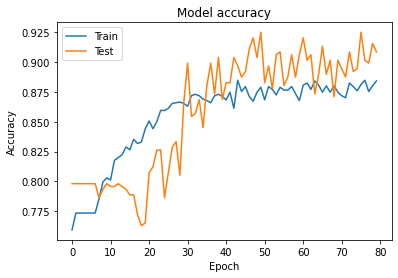

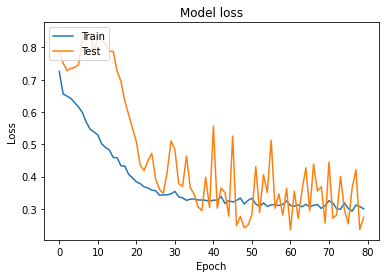

In [0]:
# Plot training & validation accuracy values on original data
plt.plot(hist1.history['accuracy'])
plt.plot(hist1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.figure()
# Plot training & validation loss values
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
results = densenn.evaluate(dn_xtest, y_test, batch_size=24)
print('test loss, test acc:', results)

18/18 [==============================] - 0s 2ms/step - loss: 0.2734 - accuracy: 0.9085
test loss, test acc: [0.27340543270111084, 0.908450722694397]


Running the NN model a number of times to get average accuracy:

In [0]:
# get mean
n = 10
plotss = []

for i in range(n):
  densenn = Sequential()

  densenn.add(Dense(128))
  densenn.add(LeakyReLU(alpha=0.3))

  densenn.add(Dense(8))
  densenn.add(LeakyReLU(alpha=0.3))

  densenn.add(Dense(3, activation="softmax"))
  densenn.compile(optimizer="adam", loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  densenn.fit(dn_xtrain, y_train, batch_size=24, epochs=80,
                    kernel_regularizer=regularizers.l2(0.0001))
  plotss.append(densenn.evaluate(dn_xtest, y_test, batch_size=24)[1])


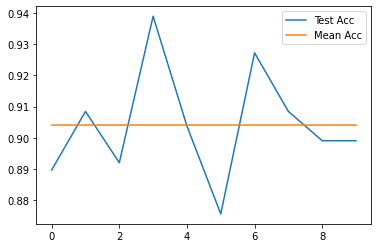

In [0]:
plt.plot(plotss)
plt.plot([np.mean(plotss) for i in range(n)])
plt.legend(["Test Acc", "Mean Acc"])

# Feature space reshaped CNN:

In [0]:
re_xtrain = []
re_xtest = []
ox, oy = 3, 7
scale = 4
x, y = ox*scale, oy*scale

for i in dn_xtrain:
  img = i.reshape((ox,oy))
  re_xtrain.append(cv2.resize(img, (x, y), interpolation = cv2.INTER_AREA))

for i in dn_xtest:
  img = i.reshape((ox,oy))
  re_xtest.append(cv2.resize(img, (x, y), interpolation = cv2.INTER_AREA))

re_xtrain = np.array(re_xtrain)
re_xtest = np.array(re_xtest)

In [0]:
fscnn = Sequential()

fscnn.add(Reshape((1, x, y)))

fscnn.add(Conv2D(32, (2,2), padding='same', name="conv1-1"))
fscnn.add(Conv2D(32, (2,2), padding='same', name="conv1-2"))
fscnn.add(Dropout(0.1))
fscnn.add(Conv2D(64, (2,2), padding='same', name="conv1-3"))
fscnn.add(LeakyReLU(alpha=0.3))

fscnn.add(Flatten())

fscnn.add(Dense(8))
fscnn.add(LeakyReLU(alpha=0.3))

fscnn.add(Dense(3, activation="softmax"))

In [0]:
fscnn.compile(optimizer="adam", loss='sparse_categorical_crossentropy',  
                metrics=['accuracy'])
hist3 = fscnn.fit(re_xtrain, y_train, batch_size=32, epochs=60, 
                       validation_data=(re_xtest, y_test))

Epoch 1/60
54/54 [==============================] - 0s 5ms/step - loss: 0.6935 - accuracy: 0.7565 - val_loss: 0.8084 - val_accuracy: 0.7981
Epoch 2/60
54/54 [==============================] - 0s 4ms/step - loss: 0.6396 - accuracy: 0.7735 - val_loss: 0.8033 - val_accuracy: 0.7981
Epoch 3/60
54/54 [==============================] - 0s 3ms/step - loss: 0.6062 - accuracy: 0.7771 - val_loss: 0.9573 - val_accuracy: 0.7089
Epoch 4/60
54/54 [==============================] - 0s 3ms/step - loss: 0.5321 - accuracy: 0.8041 - val_loss: 0.7918 - val_accuracy: 0.7676
Epoch 5/60
54/54 [==============================] - 0s 3ms/step - loss: 0.4743 - accuracy: 0.8206 - val_loss: 0.6620 - val_accuracy: 0.7324
Epoch 6/60
54/54 [==============================] - 0s 3ms/step - loss: 0.4276 - accuracy: 0.8365 - val_loss: 0.6089 - val_accuracy: 0.7746
Epoch 7/60
54/54 [==============================] - 0s 4ms/step - loss: 0.3866 - accuracy: 0.8482 - val_loss: 0.7476 - val_accuracy: 0.7371
Epoch 8/60
54/54 [==

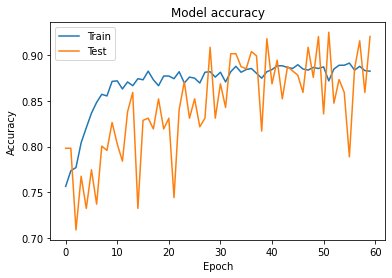

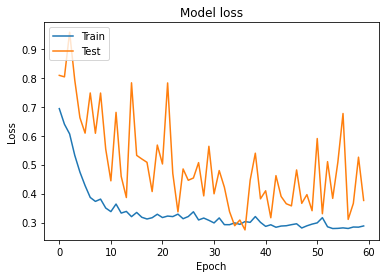

In [0]:
# Plot training & validation accuracy values
plt.plot(hist3.history['accuracy'])
plt.plot(hist3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.figure()
# Plot training & validation loss values
plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
results = fscnn.evaluate(re_xtest, y_test, batch_size=32)
print('test loss, test acc:', results)

14/14 [==============================] - 0s 2ms/step - loss: 0.3764 - accuracy: 0.9202
test loss, test acc: [0.37635383009910583, 0.920187771320343]


Include more performance metrics, "Sensitivity (TPR), specificity(SPC), accuracy(ACC),and  selectivity(SPE)"